In [50]:
# import libraries

import numpy as np

from cil.optimisation.algorithms import FISTA, PDHG
from cil.optimisation.functions import L2NormSquared, KullbackLeibler, TotalVariation, OperatorCompositionFunction
from cil.optimisation.operators import BlockOperator, GradientOperator
from cil.framework import ImageGeometry, AcquisitionGeometry, AcquisitionData, BlockDataContainer
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.plugins.ccpi_regularisation.functions import FGP_TV  
from cil.utilities.display import plotter2D
from cil.utilities.dataexample import TestData
from cil.utilities import noise

import os, sys

import tomophantom
from tomophantom import TomoP2D

import matplotlib.pyplot as plt

In [2]:
# Load a tomophantom image 
model = 8 # select a model number from the library
N = 256 # set dimension of the phantom
path = os.path.dirname(tomophantom.__file__)
path_library2D = os.path.join(path, "Phantom2DLibrary.dat")

phantom2D_np = TomoP2D.Model(model, N, path_library2D)    
ig = ImageGeometry(voxel_num_x=N, voxel_num_y=N, voxel_size_x = 0.5, voxel_size_y = 0.5)

phantom2D = ig.allocate()
phantom2D.fill(phantom2D_np)

In [3]:
# Create Acquisition Geometry

detectors =  int(np.sqrt(2)*N)
angles = np.linspace(0, np.pi, 90, dtype=np.float32)

ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles,angle_unit="radian")\
                        .set_panel(detectors, pixel_size=0.5)

In [4]:
device = "gpu"

In [5]:
# Create Projection Operator
A = ProjectionOperator(ig, ag, device )

In [53]:
# Create projection data and corrupt with noise
np.random.seed(10)

data = A.direct(phantom2D)
noisy_data = ag.allocate()
# noisy_data.fill(data.as_array() + np.random.normal(0, 0.5, ag.shape) +noisy_data.max()+0.01)
# noisy_data = noise.poisson(data)
# Add poisson noise
# n1 = TestData.random_noise(data, mode = 'poisson', seed = 10)
# noisy_data = data.geometry.allocate()
n1 = np.random.poisson(data.as_array())
noisy_data.fill(n1)

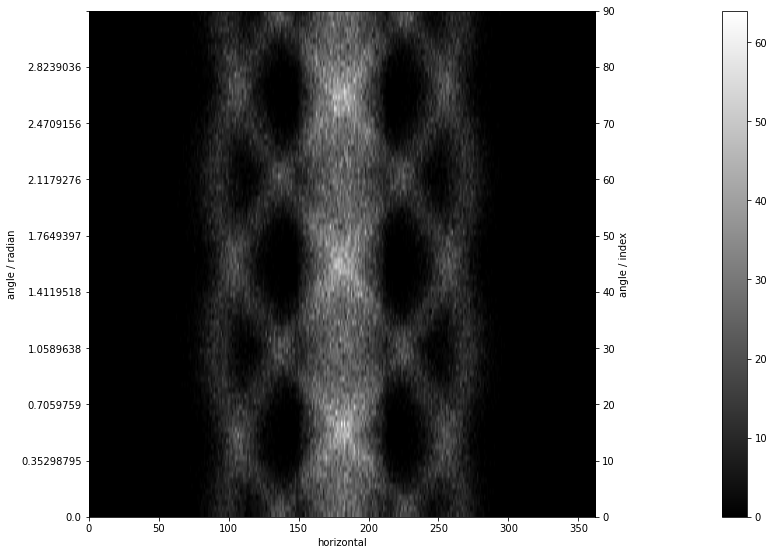

In [54]:
plotter2D(noisy_data)

In [55]:
print(noisy_data.max(), rescdata.max())
print(alphaTV, alphaTV/normK)

64.0 0.6105808
2 0.026814944052390318


In [56]:
# Regularisation parameter
alphaTV = 2

In [58]:
f = KullbackLeibler(b=data)
# gTV = alphaTV * TotalVariation(max_iteration=100, lower = 0.)
gTV = FGP_TV(alphaTV/ig.voxel_size_x, iterationsTV=100, tolerance=1e-6, methodTV=1, nonnegativity=1, printing=0, device="gpu")

K = A
normK = K.norm()
sigma = 1./normK
tau = 1./normK
pdhg_explicit = PDHG(f=f, g=gTV, operator=K, sigma=sigma, tau=tau,
           max_iteration=500, update_objective_interval=100)
pdhg_explicit.run(verbose=2)



PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        500         0.000            inf  -0.00000e+00            inf
      100        500         0.075            inf   2.53442e+03            inf
      200        500         0.074            inf   2.53962e+03            inf
      300        500         0.075            inf   2.54172e+03            inf
      400        500         0.074            inf   2.54272e+03            inf
      500        500         0.074            inf   2.54321e+03            inf
----------------------------------------------------------------------------
      500        500         0.074            inf   2.54321e+03            inf
Stop criterion has been reached.



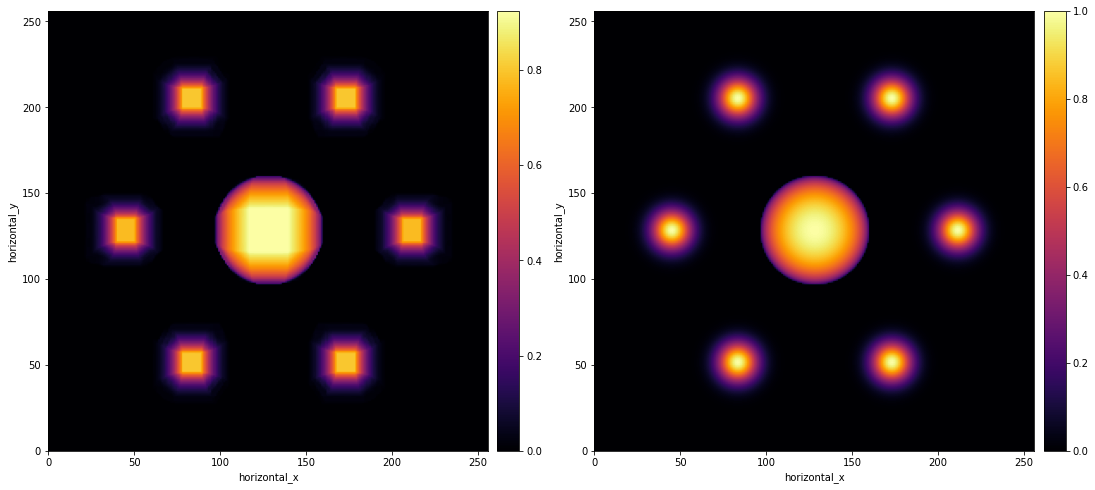

In [38]:
plotter2D([pdhg_explicit.solution,phantom2D], cmap="inferno")

In [39]:
rescK = (1/normK)*K
rescdata = data/normK
norm_rescK = rescK.norm()
f_resc = KullbackLeibler(b=rescdata)
# gTV = alphaTV/normK * TotalVariation(max_iteration=100, lower = 0.)
gTV = FGP_TV(alphaTV/(normK*ig.voxel_size_x), iterationsTV=100, tolerance=1e-6, methodTV=1, nonnegativity=1, printing=0, device="gpu")
print(rescK)
sigma = 1./norm_rescK
tau = 1./norm_rescK
pdhg_resc = PDHG(f=f_resc, g=gTV, operator=rescK, sigma=sigma, tau=tau,
           max_iteration=100, update_objective_interval=100)
pdhg_resc.run(verbose=2)



PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        100         0.000            inf  -0.00000e+00            inf
      100        100         0.076            inf   3.39802e+01            inf
----------------------------------------------------------------------------
      100        100         0.076            inf   3.39802e+01            inf
Stop criterion has been reached.



In [33]:
print(normK,norm_rescK)

74.58527588543365 1.0


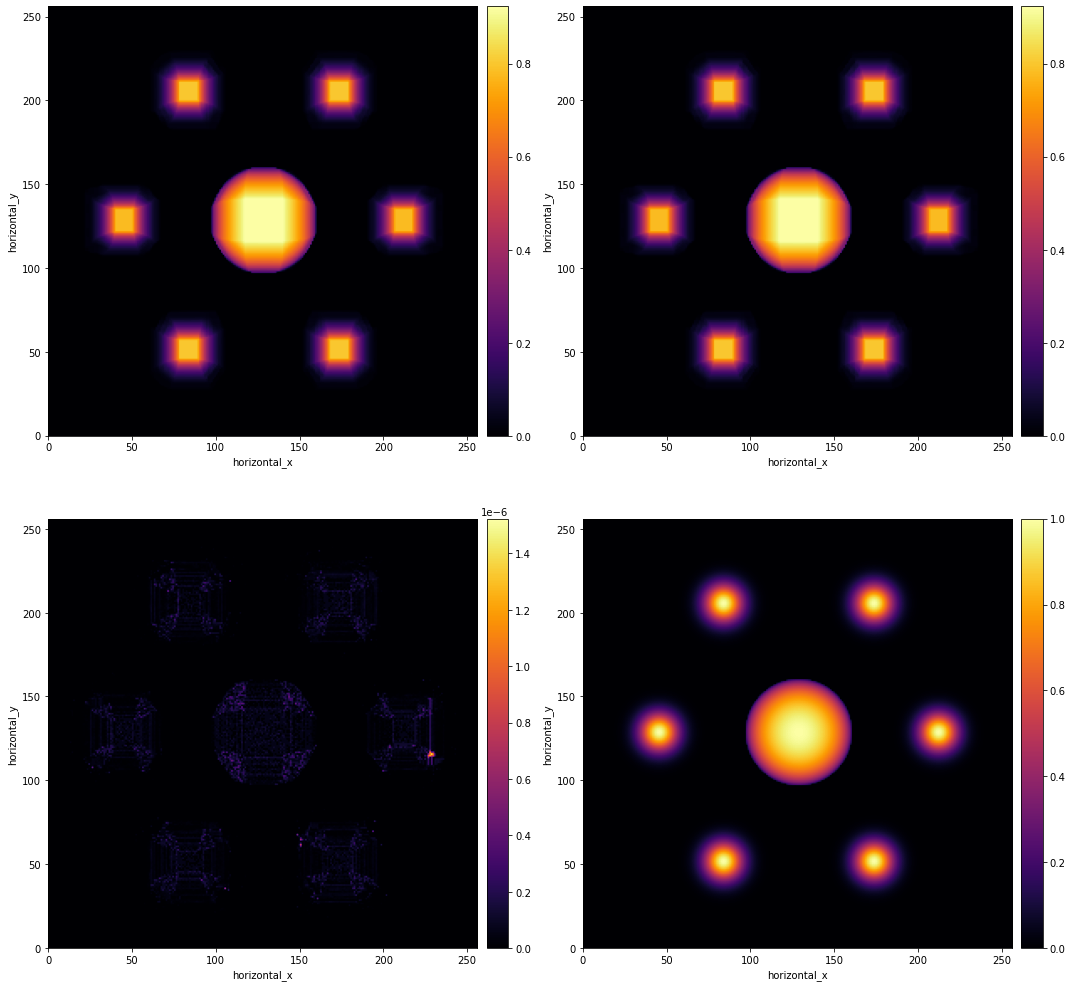

In [40]:
plotter2D([pdhg_resc.solution, pdhg_explicit.solution, (pdhg_explicit.solution - pdhg_resc.solution).abs(), phantom2D], cmap="inferno")




In [10]:
# Setup and run FISTA algorithm with different regularisers
f = OperatorCompositionFunction(0.5 * L2NormSquared(b=noisy_data), A)
gTV = alpha * TotalVariation(max_iteration=100, lower = 0.)


fista = FISTA(initial=ig.allocate(),f=f, g=g, max_iteration=200, update_objective_interval=50)
fista.run(verbose=1)

# Grad = GradientOperator(ig)
# K = BlockOperator(A, Grad)

# normK = K.norm()
# sigma = 1.
# tau = 1./(sigma*normK**2)

# pdhg_explicit = PDHG(f=f, g=g, operator=K, sigma=sigma, tau=tau,
#            max_iteration=1000, update_objective_interval=100)
# pdhg_explicit.run(verbose=2)

FISTA setting up
FISTA configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
Initialised GradientOperator with C backend running with  20  threads
        0        500         0.000          1.98606e+06
       50        500         0.229          5.94439e+03
      100        500         0.231          5.93580e+03
      150        500         0.230          5.93561e+03
      200        500         0.229          5.93555e+03
      250        500         0.229          5.93555e+03
      300        500         0.230          5.93555e+03
      350        500         0.230          5.93554e+03
      400        500         0.230          5.93554e+03
      450        500         0.230          5.93555e+03
      500        500         0.230          5.93554e+03
-------------------------------------------------------
      500        500         0.230          5.93554e+03
Stop criterion has been reached.



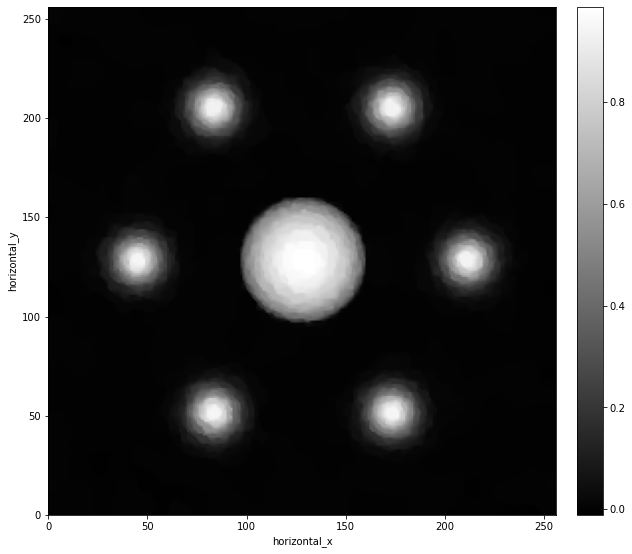

In [11]:
plotter2D(fista.solution)

In [9]:
# Setup and run PDHG (implicit) algorithm, using TotalVariation function (cpu)
f1 = 0.5 * L2NormSquared(b=noisy_data)
g1 = alpha * TotalVariation(max_iteration=100,lower=0.0)

K1 = A

normK = K1.norm()
sigma = 1./normK
tau = 1./normK

pdhg_implicit_cpu = PDHG(f=f1, g=g1, operator=K1, sigma=sigma, tau=tau,
           max_iteration=500, update_objective_interval=100)
pdhg_implicit_cpu.run(verbose=2)

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
Initialised GradientOperator with C backend running with  20  threads
        0        500         0.000    1.98606e+06  -0.00000e+00    1.98606e+06
      100        500         0.292    6.02183e+03   5.86275e+03    1.59077e+02
      200        500         0.295    5.95029e+03   5.94127e+03    9.02026e+00
      300        500         0.298    5.94885e+03   5.95933e+03   -1.04827e+01
      400        500         0.300    5.94884e+03   5.96033e+03   -1.14851e+01
      500        500         0.299    5.94888e+03   5.96045e+03   -1.15713e+01
----------------------------------------------------------------------------
      500        500         0.299    5.94888e+03   5.96045e+03   -1.15713e+01
Stop criterion has been reached.



In [10]:
# Setup and run PDHG (implicit) algorithm, using TotalVariation function (cpu)
f2 = 0.5 * L2NormSquared(b=noisy_data)
g2 = FGP_TV(alpha/ig.voxel_size_x, iterationsTV=100, tolerance=1e-6, methodTV=1, nonnegativity=1, printing=0, device="gpu")

K1 = A

normK = K1.norm()
sigma = 1./normK
tau = 1./normK

pdhg_implicit_gpu = PDHG(f=f1, g=g1, operator=K1, sigma=sigma, tau=tau,
           max_iteration=500, update_objective_interval=100)
pdhg_implicit_gpu.run(verbose=2)


PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        500         0.000    1.98606e+06  -0.00000e+00    1.98606e+06
      100        500         0.305    6.02183e+03   5.86275e+03    1.59077e+02
      200        500         0.318    5.95029e+03   5.94127e+03    9.02026e+00
      300        500         0.409    5.94885e+03   5.95933e+03   -1.04827e+01
      400        500         0.473    5.94884e+03   5.96033e+03   -1.14851e+01
      500        500         0.470    5.94888e+03   5.96045e+03   -1.15713e+01
----------------------------------------------------------------------------
      500        500         0.470    5.94888e+03   5.96045e+03   -1.15713e+01
Stop criterion has been reached.



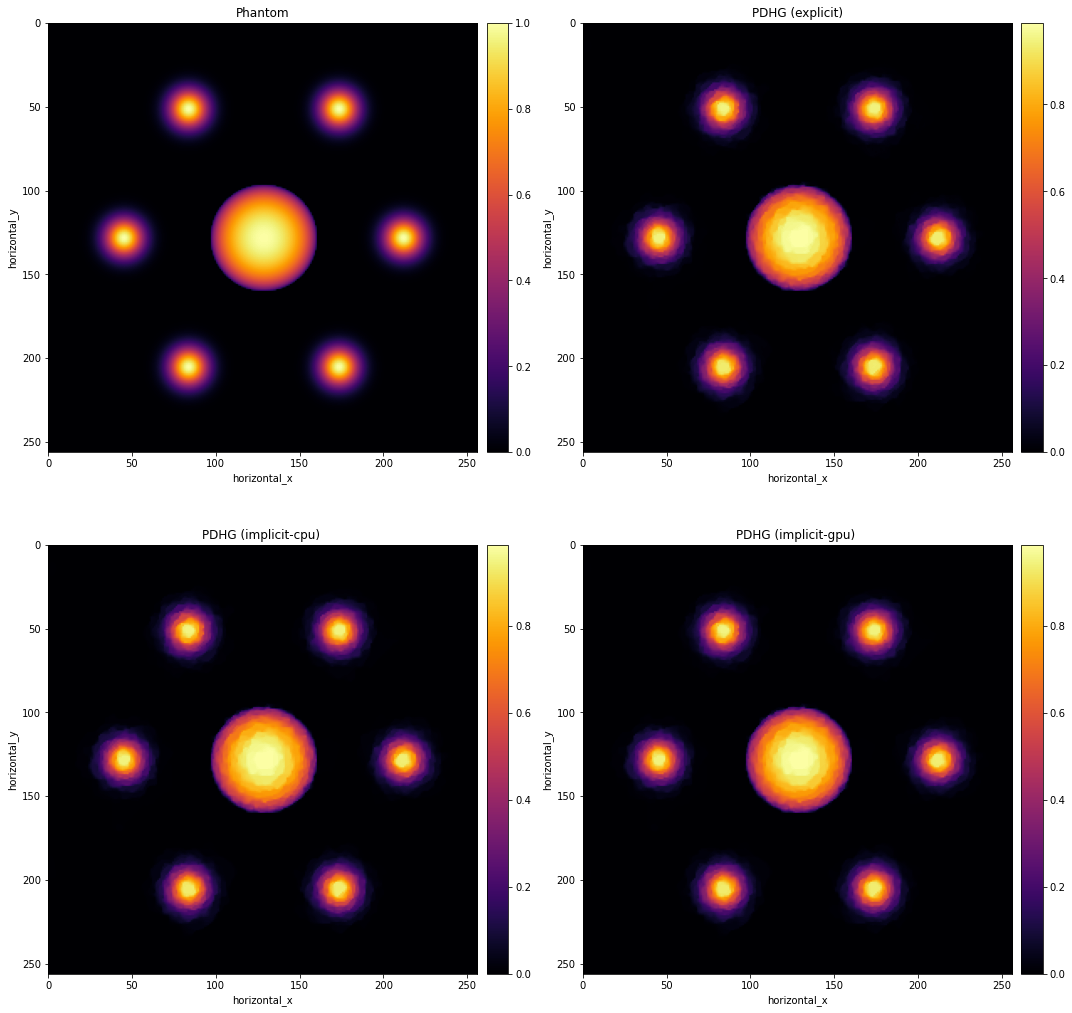

In [15]:
plotter2D([phantom2D, pdhg_explicit.solution, pdhg_implicit_cpu.solution,  pdhg_implicit_gpu.solution],
          title=["Phantom", "PDHG (explicit)", "PDHG (implicit-cpu) ", "PDHG (implicit-gpu) "],
         origin = "upper", cmap="inferno")